In [1]:
%matplotlib notebook
import warnings
import numpy as np
import matplotlib.pyplot as plt
import hera_cal
import glob, os
import cPickle as cp
import aipy
import time

In [2]:
Nants = 37

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
idxs = np.arange(Nants)
antpos = {}
for k,v in zip(idxs,ants):
    antpos[k] = v
    
redbls = hera_cal.redcal.get_pos_reds(antpos)

In [3]:
def genA(redbls):
    # number of parameters = num_ants + num_unique baselines
    N = Nants + len(redbls)
    
    # number of measurements = total number of baselines
    allbls = [bl for red in redbls for bl in red]
    M = len(allbls)
    
    A = np.zeros([M,N],dtype=np.complex)
    i = 0
    for bl,reds in enumerate(redbls):
        for pair in reds:
            A[i,pair[0]] = (1+1j)
            A[i,pair[1]] = (1-1j)
            A[i,Nants+bl] = 1+1j
            i += 1
    return np.matrix(A)

def plot_ants(antpos):
    for k,v in antpos.items():
        plt.plot(v[0],v[1],'ko')
        plt.annotate('%d'%k,xy=(v[0],v[1]),xytext=(v[0]+.5,v[1]))

def plot_redbl(redbls):
    for a1,a2 in redbls:
        plt.plot([antpos[a1][0],antpos[a2][0]],[antpos[a1][1],antpos[a2][1]],'k-')

<IPython.core.display.Javascript object>


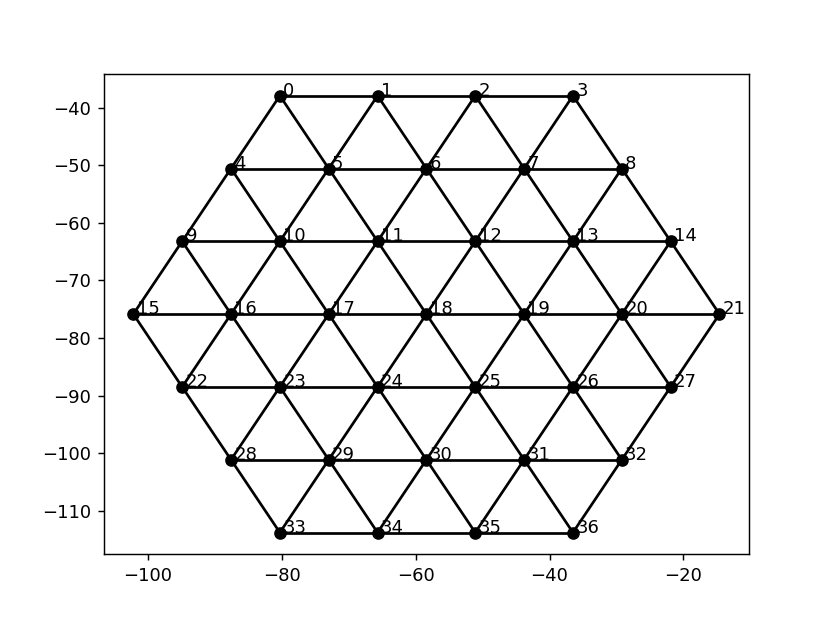

In [4]:
plt.figure()
plot_ants(antpos)
plot_redbl(redbls[0]); plot_redbl(redbls[1]); plot_redbl(redbls[2])
# plot_redbl(redbls[3]); plot_redbl(redbls[4]); plot_redbl(redbls[5])
#plot_redbl(redbls[6])

# Minimal unit

The smallest repeating unit that has redundant baselines with number of measurements greater than number of equation is the 7 antenna hexagon.

# The A matrix

Generate the A matrix (the system of equations) to then study the properties of the system through SVD analysis. The system of equations represented by the A matrix is variable-separable into the real and imaginary parts. 

The **real part represents the absolute gain solutions** and the **imaginary part represents the phase of the gain solutions**.

In [5]:
A = genA(redbls)
M,N = np.shape(A)
print M,N

666 100


<IPython.core.display.Javascript object>


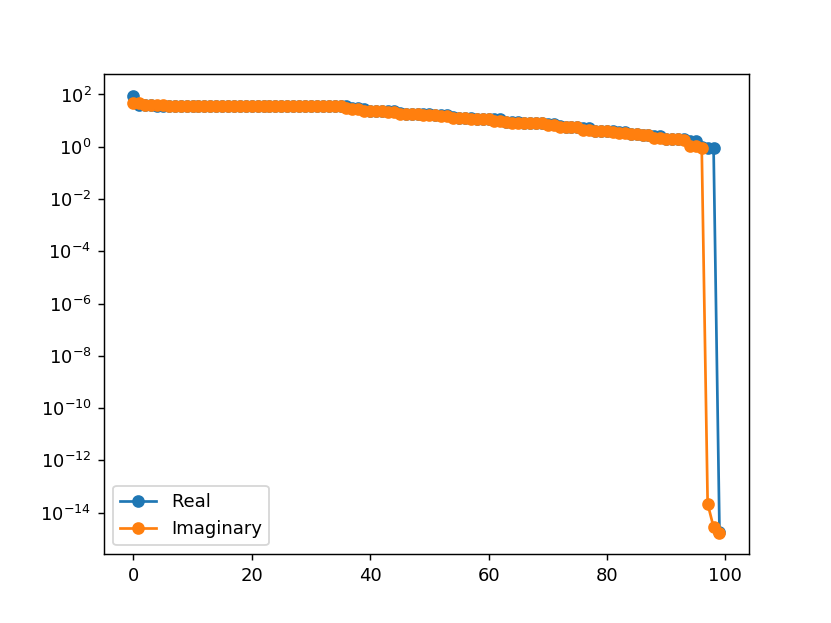

In [7]:
# Find the SVD of the real and imaginary parts of A

Mr = np.dot(np.real(A.T), np.real(A))
Mi = np.dot(np.imag(np.conjugate(A.T)), np.imag(A))

Ur,Sr,Vr = np.linalg.svd(Mr)
Ui,Si,Vi = np.linalg.svd(Mi)

plt.figure()
plt.semilogy(Sr,'o-',label='Real')
plt.semilogy(Si,'o-',label='Imaginary')
plt.legend()
plt.show()

In [ ]:
Acov = np.cov(A,rowvar=False)

In [ ]:
plt.figure(figsize=(9,5))
plt.subplot(121)
plt.title('Real A_T*A')
plt.imshow(Mr)
plt.colorbar(shrink=0.5)
plt.subplot(122)
plt.title('Covariance matrix')
plt.imshow(np.real(np.linalg.pinv(Acov))[:Nants,:Nants])#,vmin=0.1)
plt.colorbar(shrink=0.5)

## Degeneracies

To check if the degenerate modes you see in the above eigen spectrum are really the absolute gain, phase and phase slope- add those equations back as constraints and see if the degenerate vectors disappear.

$$\Sigma \eta_i = 0$$

$$\Sigma \phi_i = 0$$

$$\Sigma r_{x,i}\phi_i = 0$$

$$\Sigma r_{y,i}\phi_i = 0$$

<IPython.core.display.Javascript object>


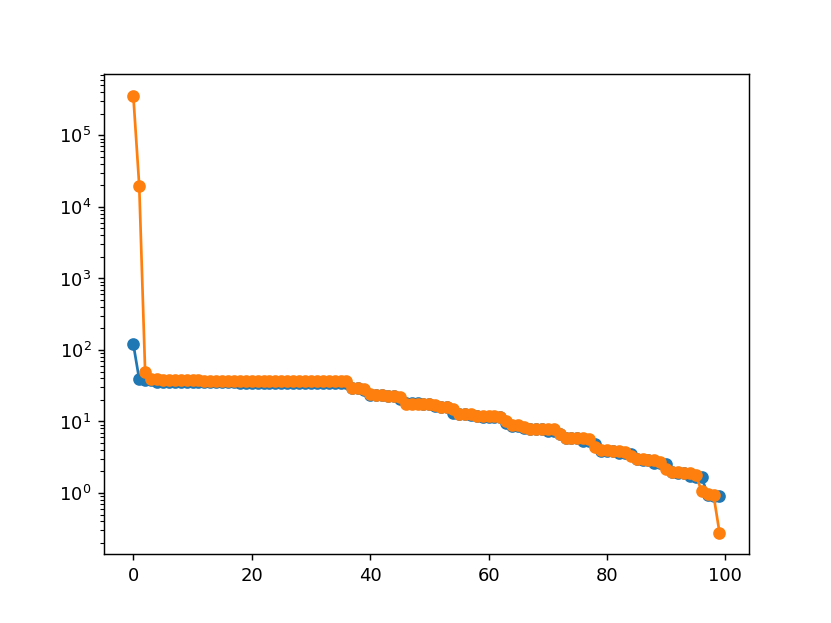

In [8]:
# Add constraints

Acond = np.zeros([M+3,N],dtype=np.complex)
Acond[:M,:] = A

for ant in range(Nants):
    Acond[M, ant] = (1+1j)
    Acond[M+1, ant] = 1j*antpos[ant][0]
    Acond[M+2, ant] = 1j*antpos[ant][1]
    
Mconr = np.dot(np.real(Acond.T), np.real(Acond))
Mconi = np.dot(np.imag(np.conjugate(Acond.T)), np.imag(Acond))

Ucr,Scr,Vcr = np.linalg.svd(Mconr)
Uci,Sci,Vci = np.linalg.svd(Mconi)

plt.figure()
plt.semilogy(Scr,'o-',label='Real')
plt.semilogy(Sci,'o-',label='Imaginary')

In [9]:
# Compare U and V for the real and imaginary parts.
# Since A.T * A is symmetric, U and V should be equal.

print np.all(np.isclose(Ucr,Vcr.T))
print np.all(np.isclose(Uci,(-1*Vci.T)))

True
True


# Shortest Baseline Separation

90 40


<IPython.core.display.Javascript object>


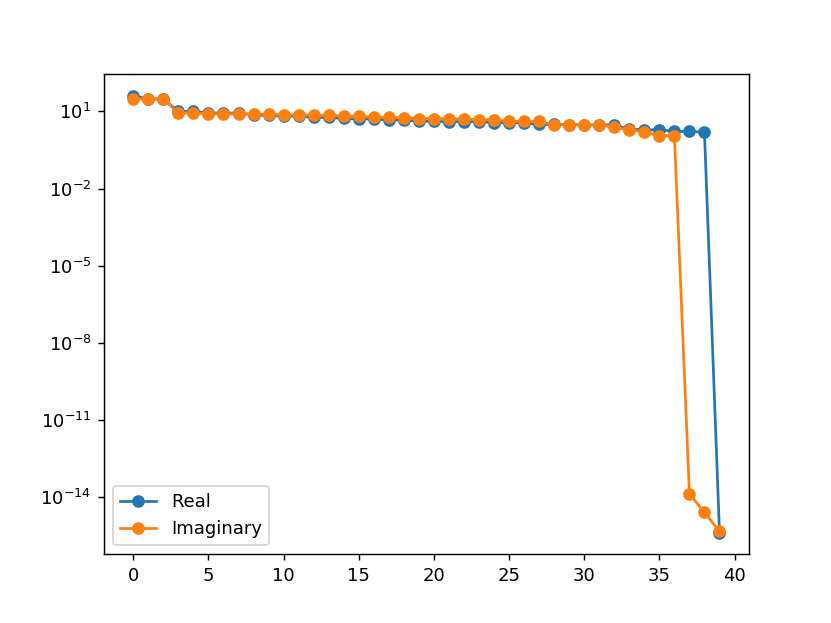

In [10]:
sub_bls = np.array([redbls[0],redbls[1],redbls[2]])
At = genA(sub_bls)
Mt,Nt = np.shape(At)
print Mt,Nt

# Find the SVD of the real and imaginary parts of A

Mrt = np.dot(np.real(At.T), np.real(At))
Mit = np.dot(np.imag(np.conjugate(At.T)), np.imag(At))

Urt,Srt,Vrt = np.linalg.svd(Mrt)
Uit,Sit,Vit = np.linalg.svd(Mit)

plt.figure()
plt.semilogy(Srt,'o-',label='Real')
plt.semilogy(Sit,'o-',label='Imaginary')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


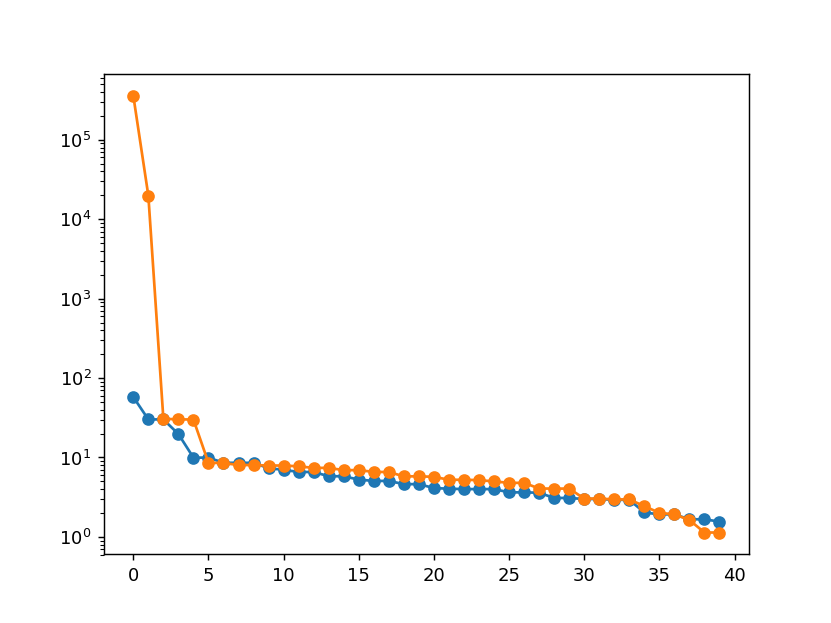

In [11]:
# Add constraints

Acond = np.zeros([Mt+3,Nt],dtype=np.complex)
Acond[:Mt,:] = At

for ant in range(Nants):
    Acond[Mt, ant] = (1+1j)
    Acond[Mt+1, ant] = 1j*antpos[ant][0]
    Acond[Mt+2, ant] = 1j*antpos[ant][1]
    
Mconr = np.dot(np.real(Acond.T), np.real(Acond))
Mconi = np.dot(np.imag(np.conjugate(Acond.T)), np.imag(Acond))

Ucr,Scr,Vcr = np.linalg.svd(Mconr)
Uci,Sci,Vci = np.linalg.svd(Mconi)

plt.figure()
plt.semilogy(Scr,'o-',label='Real')
plt.semilogy(Sci,'o-',label='Imaginary')

In [12]:
print np.all(np.isclose(Ucr,Vcr.T))
print np.all(np.isclose(Uci,(-1*Vci.T)))

True
True


# Covariance Matrix

The covariance of the gain solutions is given by: 

$$Cov(X) = (A^{\dagger}A)^{-1}$$

In [ ]:
#Acov = np.linalg.pinv(np.cov(A,rowvar=False))[:Nants,:Nants]
#Atcov = np.linalg.pinv(np.cov(At,rowvar=False))[:Nants,:Nants]

# Marginalized covariance

<IPython.core.display.Javascript object>


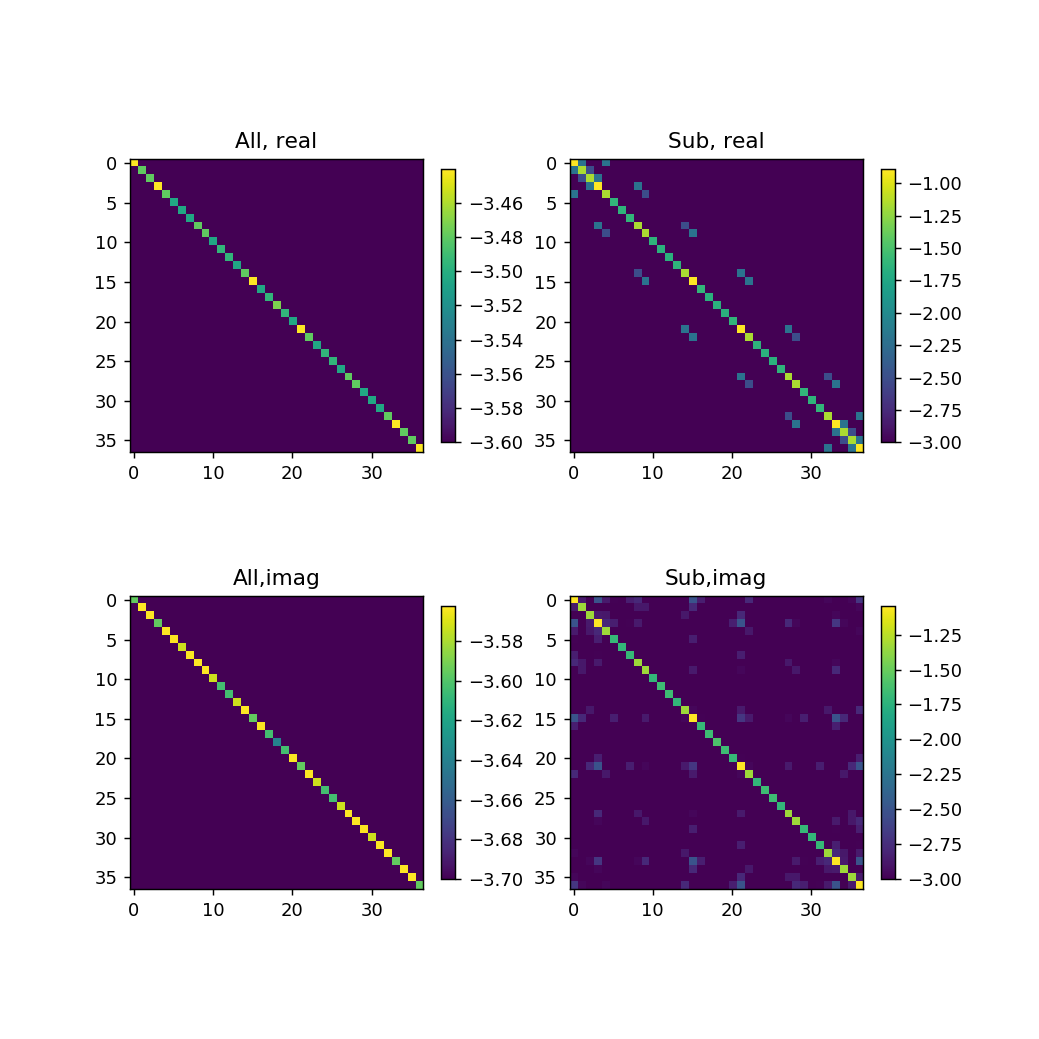

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('All, real')
covr = np.linalg.pinv(Mr)[:Nants,:Nants]
plt.imshow(np.log(np.abs(covr)),vmin=-3.6)
#plt.imshow(np.log(np.abs(np.real(Acov))),vmin=-2)
plt.colorbar(shrink=0.75)
plt.subplot(222)
plt.title('Sub, real')
covtr = np.linalg.pinv(Mrt)[:Nants,:Nants]
plt.imshow(np.log(np.abs(covtr)),vmin=-3)
#plt.imshow(np.log(np.abs(np.real(Atcov))),vmin=-3)
plt.colorbar(shrink=0.75)

plt.subplot(223)
plt.title('All,imag')
covi = -1*np.linalg.pinv(Mi)[:Nants,:Nants]
plt.imshow(np.log(np.abs(covi)),vmin=-3.7)
#plt.imshow(np.imag(Acov),cmap='PiYG',vmax=2,vmin=-2)
plt.colorbar(shrink=0.75)
plt.subplot(224)
plt.title('Sub,imag')
covti = -1*np.linalg.pinv(Mit)[:Nants,:Nants]
plt.imshow(np.log(np.abs(covti)),vmin=-3)
#plt.imshow(np.imag(Atcov),cmap='PiYG',vmin=-4,vmax=4)
plt.colorbar(shrink=0.75)

In [32]:
np.diag(covr)

array([0.03204841, 0.03082263, 0.03082263, 0.03204841, 0.03082263,
       0.03004635, 0.03005222, 0.03004635, 0.03082263, 0.03082263,
       0.03005222, 0.03034176, 0.03034176, 0.03005222, 0.03082263,
       0.03204841, 0.03004635, 0.03034176, 0.03106495, 0.03034176,
       0.03004635, 0.03204841, 0.03082263, 0.03005222, 0.03034176,
       0.03034176, 0.03005222, 0.03082263, 0.03082263, 0.03004635,
       0.03005222, 0.03004635, 0.03082263, 0.03204841, 0.03082263,
       0.03082263, 0.03204841])

In [33]:
np.diag(covi)

array([0.02744235, 0.02837028, 0.02837028, 0.02744235, 0.02837028,
       0.02834611, 0.02807555, 0.02834611, 0.02837028, 0.02837028,
       0.02807555, 0.02723205, 0.02723205, 0.02807555, 0.02837028,
       0.02744235, 0.02834611, 0.02723205, 0.02629657, 0.02723205,
       0.02834611, 0.02744235, 0.02837028, 0.02807555, 0.02723205,
       0.02723205, 0.02807555, 0.02837028, 0.02837028, 0.02834611,
       0.02807555, 0.02834611, 0.02837028, 0.02744235, 0.02837028,
       0.02837028, 0.02744235])

### Calibration coefficient

$$\Sigma N_{rb} * N_{a}$$

- $N_a$ is number of times that antenna is involved in a baseline seperation
- $N_{rb}$ is the total number of baseline pairs of that separation

In [34]:
def calib_coeff(antenna,redbls):
    #Number of times antenna is involved in that redundant set
    Na = np.array([l.count(antenna) for l in [[ant for pair in bls for ant in pair] for bls in redbls]])
    Nbl = np.array([len(bls) for bls in redbls])
    return np.sum(Nbl*Na)

<IPython.core.display.Javascript object>


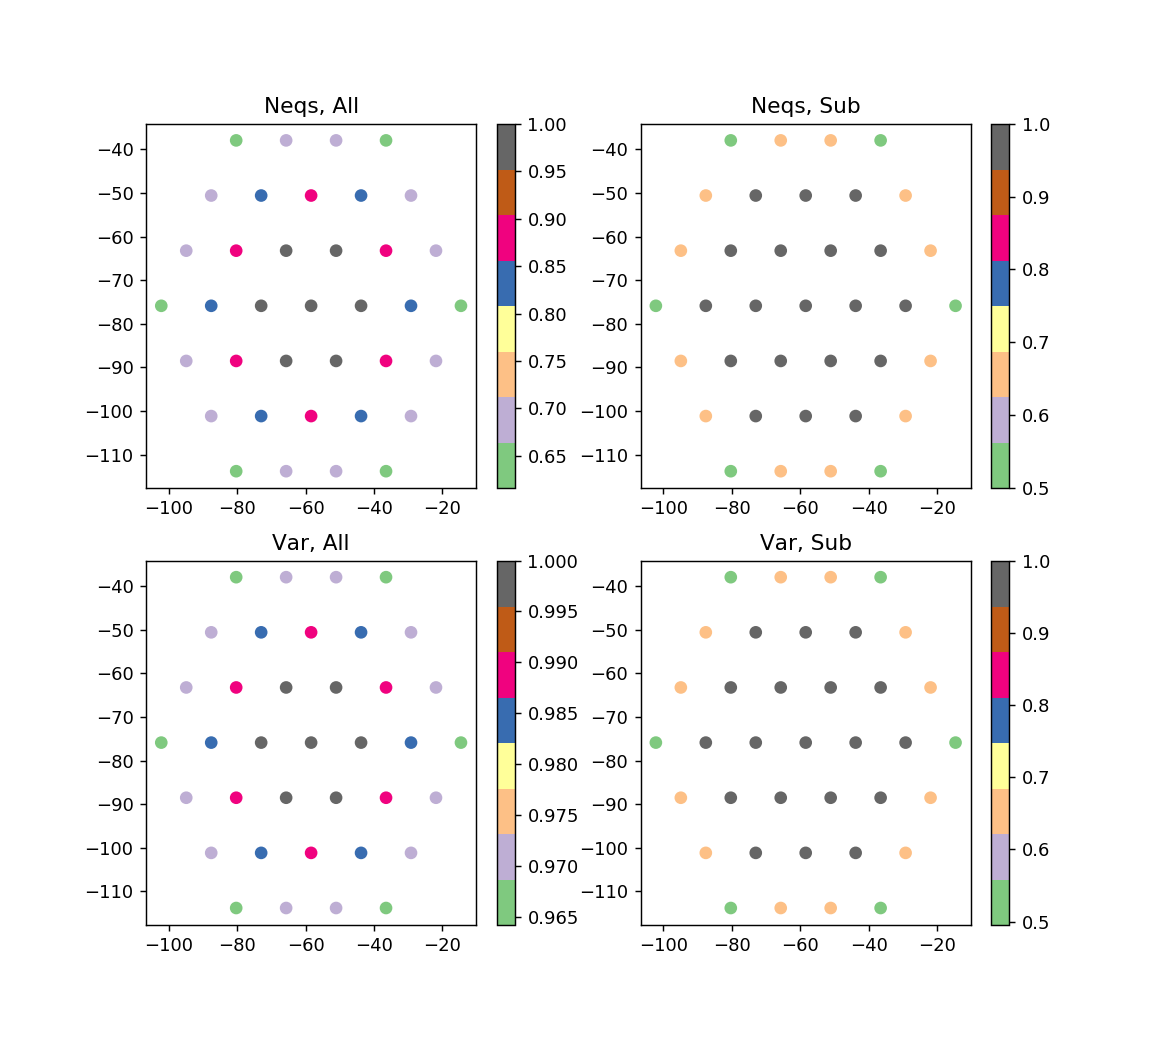

In [53]:
#neqs = np.ones([Nants,Nants])
#neqs_sub = np.ones([Nants,Nants])

neqs = np.zeros(Nants)
neqs_sub = np.zeros(Nants)
for a in range(Nants):
    neqs[a] = calib_coeff(a,redbls)
    neqs_sub[a] = calib_coeff(a,sub_bls)
    
x = [v[0] for v in antpos.values()]
y = [v[1] for v in antpos.values()]

plt.figure(figsize=(9,8))
plt.subplot(221)
plt.title('Neqs, All')
plt.scatter(x,y,c=neqs/np.max(neqs),cmap='Accent')
#plt.imshow(np.log(neqs),vmin=6)
plt.colorbar()
plt.subplot(222)
plt.title('Neqs, Sub')
plt.scatter(x,y,c=neqs_sub/np.max(neqs_sub),cmap='Accent')
#plt.imshow(np.log(neqs_sub),vmin=4)
plt.colorbar()
plt.subplot(223)
plt.title('Var, All')
var_all = np.diag(covr)+np.diag(covi)
plt.scatter(x,y,c=np.min(var_all)/var_all,cmap='Accent')
plt.colorbar()
plt.subplot(224)
plt.title('Var, Sub')
var_sub = np.diag(covtr)+np.diag(covti)
plt.scatter(x,y,c=np.min(var_sub)/var_sub,cmap='Accent')#cmap='Spectral')
plt.colorbar()
plt.show()

# Conditional Covariance

The question to ask is: What is the covariance matrix of the gain solutions after you have solved the entire system of equations? How does this covariance change if you solve only a subsystem of the equations?

The answer to the first question is given by the conditional covariance matrix. If you assume gaussian statistics for all the variables (gains and visibilities), this conditional covariance matrix is given by the following process:

1. Invert the full covariance matrix
2. Drop the rows and columns for the variables to condition on
3. Invert back to get the conditional covariance matrix

## Is conditional covariance the right parameter?

Last discussion with Josh was that, conditional covariance is not very meaningful because we are not fixing the visibilities through some sky model or another parameter like that. Maybe the right matrix to consider for covariance is the marginalized gains.

In [ ]:
Acov_cond = np.linalg.pinv(np.cov(A,rowvar=False)[:Nants,:Nants])
Atcov_cond = np.linalg.pinv(np.cov(At,rowvar=False)[:Nants,:Nants])

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('All, real')
plt.imshow(np.log10(np.abs(np.real(Acov_cond))))#,vmin=-4)
plt.colorbar(shrink=0.75)

plt.subplot(222)
plt.title('Sub, real')
plt.imshow(np.log10(np.abs(np.real(Atcov_cond))))#,vmin=-3)
plt.colorbar(shrink=0.75)

plt.subplot(223)
plt.title('All, imag')
plt.imshow((np.imag(Acov_cond)))#,vmin=-4)
plt.colorbar(shrink=0.75)

plt.subplot(224)
plt.title('Sub, imag')
plt.imshow((np.imag(Atcov_cond)))#,vmin=-3)
plt.colorbar(shrink=0.75)

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.scatter(x,y,c=np.log(neqs))
#plt.imshow(np.log(neqs),vmin=6)
plt.colorbar()
plt.subplot(222)
plt.scatter(x,y,c=np.log(neqs_sub))
#plt.imshow(np.log(neqs_sub),vmin=4)
plt.colorbar()
plt.subplot(223)
plt.scatter(x,y,c=np.abs(np.diag(Acov_cond)),cmap='viridis_r')
plt.colorbar()
plt.subplot(224)
plt.scatter(x,y,c=np.abs(np.diag(Atcov_cond)),cmap='viridis_r')
plt.colorbar()
plt.show()

In [ ]:
Ur,Scr,Vr = np.linalg.svd(cond_covr)
Ui,Sctr,Vi = np.linalg.svd(cond_covr_t)

plt.figure()
plt.semilogy(Scr,'o-',label='All baselines')
plt.semilogy(Sctr,'o-',label='Truncated')
plt.legend()
plt.show()

# Log normal distribution of gains

The above plot shows the covariance of the linear additive gains (assuming they form a multivariate normal distribution). The result of log-cal that you want to compare this with, is in multiplicative gains. The multiplicative gains will form a log-normal distribution if your first assumption holds.

In [ ]:
# Generate random gains for a start

gains = np.random.normal(loc=0,scale=.01,size=Nants) + 1j*np.random.normal(loc=0,scale=np.pi,size=Nants)

plt.figure()
plt.plot(np.abs(np.exp(gains)))

In [ ]:
# Covariance of multivariate lognormal distribution
var_G = np.array(cond_covr_t+ 1j*cond_covi_t)
var_g = np.zeros((Nants,Nants),dtype=np.complex)

for i in range(Nants):
    for j in range(Nants):
        var_g[i][j] = np.exp(0.5*(var_G[i][i]+var_G[j][j]))*(np.exp(var_G[i][j])-1) 
        #gains[i]+gains[j]+

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.abs(np.real(var_g)))
plt.colorbar(shrink=0.75)
plt.subplot(122)
plt.imshow(np.abs(np.imag(var_g)))
plt.colorbar(shrink=0.75)

In [54]:
with open('sim_gain_sols.cp','r') as fp:
    input_gains, subbl_gains, allbl_gains = cp.load(fp)

IOError: [Errno 2] No such file or directory: 'sim_gain_sols.cp'

In [ ]:
for a in range(37):
    input_gains[(a,'x')] = np.asarray(input_gains[(a,'x')])
    subbl_gains[(a,'x')] = np.asarray(subbl_gains[(a,'x')])
    allbl_gains[(a,'x')] = np.asarray(allbl_gains[(a,'x')])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for ant in range(1):
    fig.suptitle('Ant %d'%ant)
    ax.clear()
    ax.semilogy(np.abs(input_gains[(ant,'x')]),'c',label='All baselines',alpha=0.3)
    ax.semilogy(np.abs(subbl_gains[(ant,'x')]-input_gains[(ant,'x')]),'b',label='Subset baselines',alpha=0.7)
    ax.semilogy(np.abs(allbl_gains[(ant,'x')]-input_gains[(ant,'x')]),'m',label='All baselines',alpha=0.3)
    time.sleep(1)
    fig.canvas.draw()

In [ ]:
all_gainres = []
sub_gainres = []

N = 2**16

for ant in input_gains.keys():
    all_gainres.append(allbl_gains[ant][:N])#-np.mean(allbl_gains[ant][:N]))
    sub_gainres.append(subbl_gains[ant][:N])#-np.mean(subbl_gains[ant][:N]))
    #all_gainres.append(allbl_gains[ant][:N]-input_gains[ant][:N])
    #sub_gainres.append(subbl_gains[ant][:N]-input_gains[ant][:N])

subcov = np.cov(sub_gainres)
allcov = np.cov(all_gainres)

#subcov = np.dot(sub_gainres, np.conjugate(sub_gainres).T)/(np.shape(sub_gainres)[1]-1)
#allcov = np.dot(all_gainres, np.conjugate(all_gainres).T)/(np.shape(all_gainres)[1]-1)

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('Sub Real')
plt.imshow(np.log10(np.real(subcov)),vmin=-3)
plt.colorbar(shrink=0.7)

plt.subplot(222)
plt.title('All real')
plt.imshow(np.log10(np.real(allcov)),vmin=-3)
plt.colorbar(shrink=0.7)

plt.subplot(223)
plt.title('Sub Imag')
plt.imshow(np.imag(subcov))
plt.colorbar(shrink=0.7)

plt.subplot(224)
plt.title('All Imag')
plt.imshow(np.imag(allcov))
plt.colorbar(shrink=0.7)

### Visualize the covariance

<IPython.core.display.Javascript object>


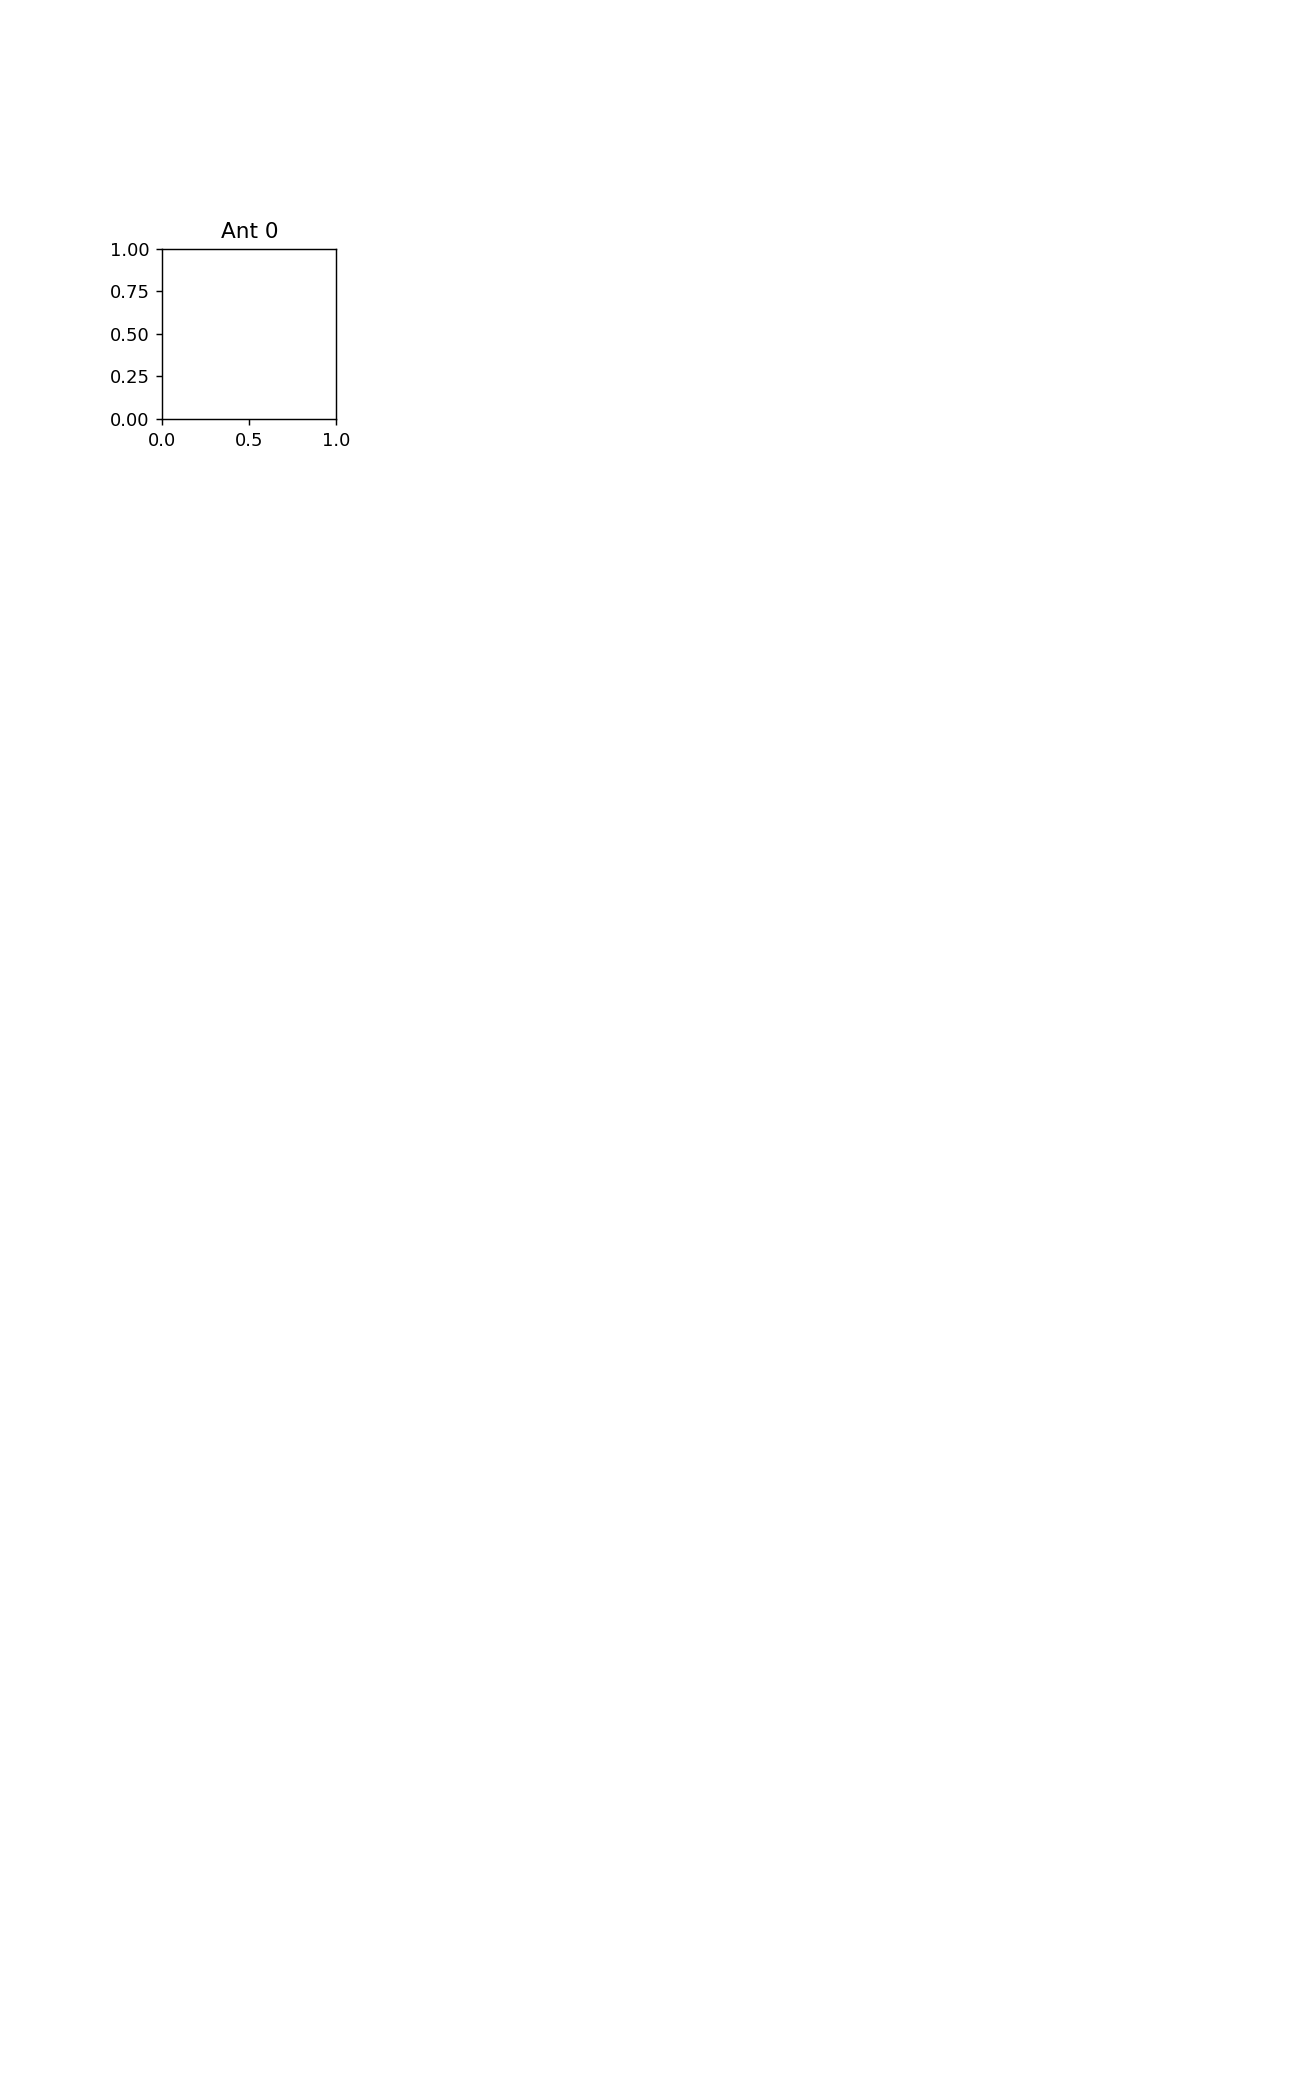

NameError: name 'cond_covr_t' is not defined

In [14]:
import matplotlib
plt.figure(figsize=(10,16))
cmap = matplotlib.cm.get_cmap('Spectral')

x = [v[0] for v in antpos.values()]
y = [v[1] for v in antpos.values()]

for i in range(37):
    plt.subplot(8,5,i+1)
    plt.title('Ant %d'%i)
    plt.scatter(x,y,c=np.abs(np.real(cond_covr_t[i])))
    plt.axis('off')

Extrapolating the above argument, it will be interesting to see how the covariance matrix will change when you consider incrementally more baselines. 

<IPython.core.display.Javascript object>


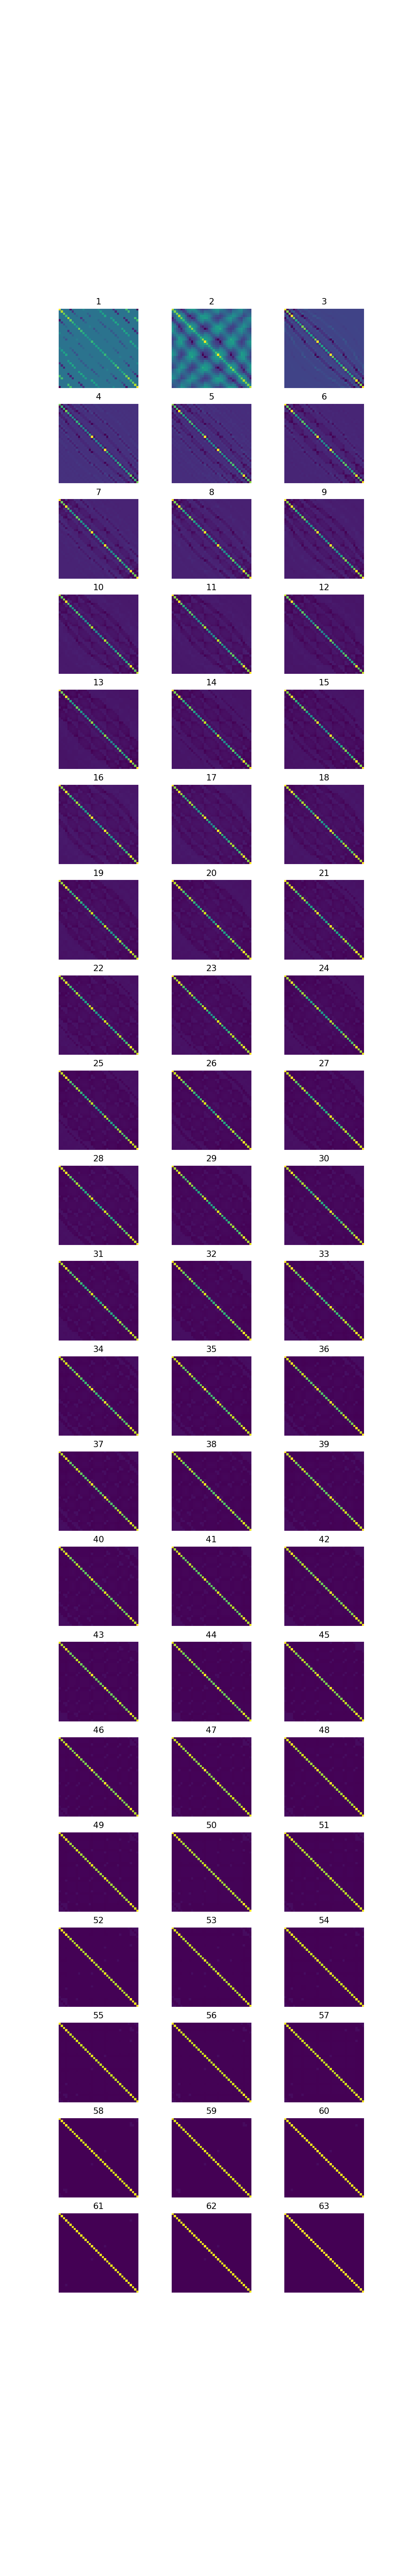

In [21]:
plt.figure(figsize=(8,50))

sub_bls = [redbls[0],redbls[1],redbls[2]]

for n,reds in enumerate(redbls):
    sub_bls = redbls[:n+1]
    Att = genA(sub_bls)
    Mrtt = np.dot(np.real(Att.T), np.real(Att))
    Mrtt_p = Mrtt[:Nants,:Nants]
    cond_cov_tt = np.linalg.pinv(Mrtt_p)
    plt.subplot(21,3,n+1)
    plt.title(n+1)
    plt.imshow(cond_cov_tt,interpolation='nearest',cmap='viridis')
    plt.axis('off')

In [ ]:
# 1. Mr is the inverse of the covariance matrix
# 2. Drop the rows and columns of visibilities


plt.matshow(cond_cov_tt)
plt.colorbar(shrink=0.5)

# Gain variation with time

How the gains vary with time directly affects how frequently you have to calibrate the antennas. 

If you calibrate only a subset of baselines you need to calibrate for longer to acheive the same SNR. But if the gain variations on short scales are high, the integration will wash out the structure.

<IPython.core.display.Javascript object>


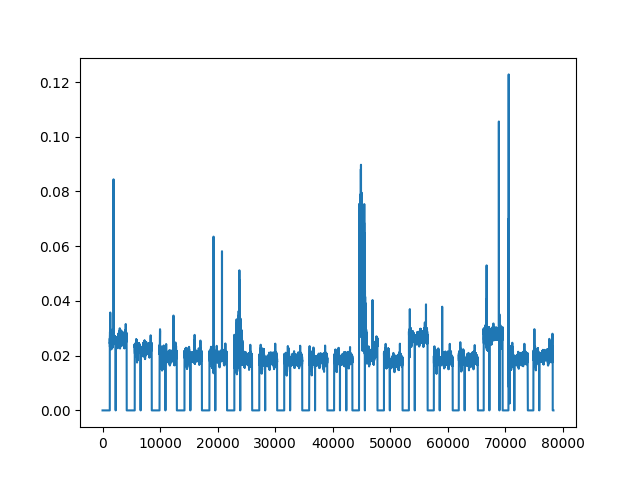

In [5]:
files = glob.glob('hera_idr2p1_gains/245*')
files.sort()

# Forgot to load this into file header
INT_TIME = 10.73741912841797

g = []; flags = []

for fn in files:
    with open(fn,'r') as fp:
        data = cp.load(fp)
    g.append(data['gains'])
    flags.append(data['flags'])
    
# Flags are 0 where there is data and 
# 1 where there is **no** data
flags = np.concatenate(np.concatenate(flags))
wgts = np.logical_not(flags)
g = np.concatenate(np.concatenate(g))

g = g * wgts

plt.figure()
plt.plot(np.abs(g))

# Single day gain variation

The above plot shows that the most of the variation is in small fringe-rates (long time periods) which is awesome because I can integrate on short scales without loss of information. Analysing a single day gain variation to confirm this.

In [6]:
with open(files[1],'r') as fp:
    data = cp.load(fp)

<IPython.core.display.Javascript object>


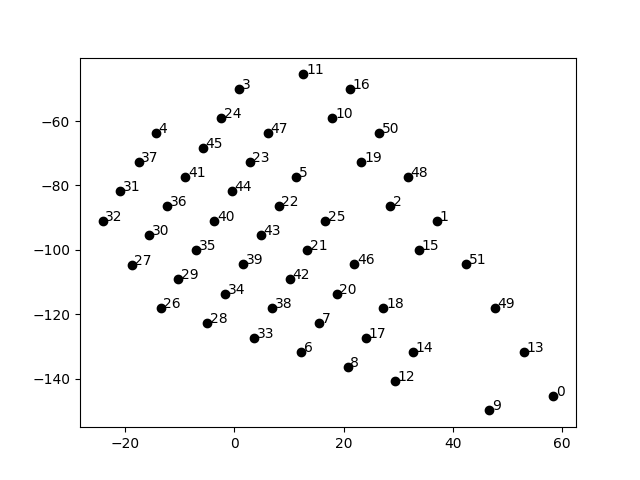

In [11]:
# Determine number of measurements = total number of baselines (including redundant)
with open('hera_idr2p1_gains/antpos_52ants.cp','r') as fp:
    antpos_52 = cp.load(fp)

redbls_52 = hera_cal.redcal.get_pos_reds(antpos_52)
allbls = [bl for red in redbls_52 for bl in red]

plt.figure()
plot_ants(antpos_52)

<IPython.core.display.Javascript object>


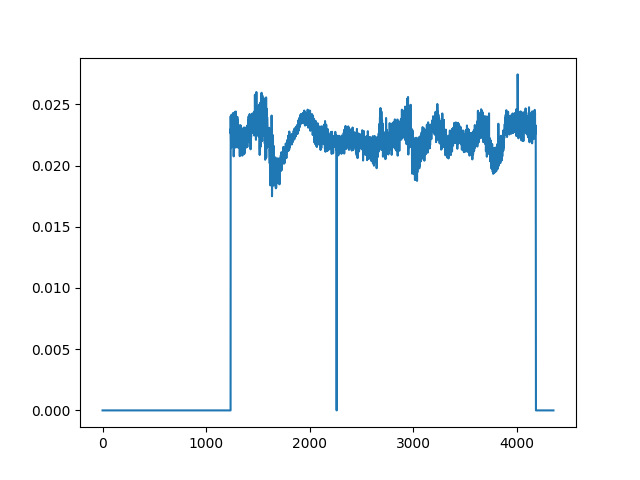

In [12]:
dflags = np.concatenate(data['flags'])
dgains = np.concatenate(data['gains'])

dwgts = np.logical_not(dflags)
dgains = dgains*dwgts

time_range = np.arange(np.size(dgains))*INT_TIME

plt.figure()
plt.plot(np.abs(dgains))

<IPython.core.display.Javascript object>


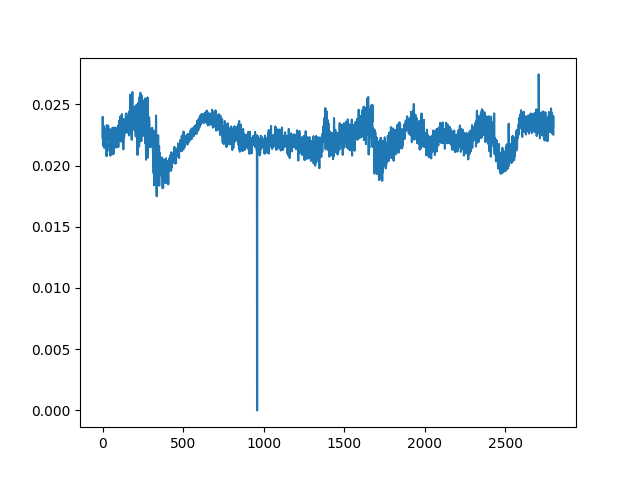

In [13]:
# Cut out flagged areas
dgains = dgains[1300:4100]
dwgts = dwgts[1300:4100]
time_range = time_range[1300:4100]

plt.figure()
plt.plot(np.abs(dgains))

In [14]:
# Deconvolve to interpolate the single flagged value

Fdg = np.fft.ifft(dgains)
Fdker = np.fft.ifft(dwgts)

fringe_rate = np.fft.fftfreq(np.size(time_range),d=INT_TIME)

Fdg_deconv = aipy.deconv.clean(im = Fdg, ker = Fdker, tol=1e-6)

In [15]:
Fdg_deconv[1]

{'iter': 10000,
 'res': array([ 1.15126642e-05-4.78090164e-06j,  9.53710223e-06-8.57199339e-06j,
         2.30114296e-06+1.33140272e-05j, ...,
         1.15237720e-05+4.23843489e-06j,  7.34129724e-06+9.93598950e-06j,
        -1.11763260e-05-6.53824098e-06j]),
 'score': 1.1682065205404882e-05,
 'success': False,
 'term': 'maxiter',
 'tol': 1e-06}

**Note**: Ifft averages, fft adds 

To check try: np.fft.fft([1,1,1,1]) and np.fft.ifft([1,1,1,1])

In [ ]:
# Interpolated and cleaned gains for a single day
gains_day = np.abs(np.fft.fft(Fdg_deconv[0] + Fdg_deconv[1]['res']))

# Check that the fourier transform converged
plt.figure()
plt.plot(time_range/(60*60),gains_day)
plt.plot(time_range/(60*60),np.abs(dgains),'--r',alpha=0.5)
plt.xlabel('Time [in hours]')

To understand how frequently you need to calibrate the gains:

1. Sample the gains at different time periods- different sampling frequencies will result in different 

In [ ]:
gain_varfft = {}
for i in range(1,100,1):
    g = gains_day[::i]
    gain_varfft[(i,'freq')] = np.fft.fftfreq(len(g),d=i*INT_TIME)
    gain_varfft[(i,'ifft')] = np.fft.ifft(g)

In [ ]:
plt.figure()
plt.semilogy(gain_varfft[(1,'freq')],np.abs(gain_varfft[(1,'ifft')])**2)

In [ ]:
plt.figure()
for i in range(10,100,10):
    plt.plot(gain_varfft[(i,'freq')],np.abs(gain_varfft[(i,'ifft')]),'.',label=i,alpha=0.7)
plt.legend()

In [ ]:
gain_varfft[(1,'freq')]

In [ ]:
plt.figure()

Tsys = 500.      # Galactic + Receiver noise
Tsrc = 5.
B = 100e6/1024
Nmeas = len(allbls)
#noise = Tsys/(np.sqrt(len(Fdg_deconv[0])*INT_TIME*B*Nmeas))

for i in range(1,100,1):
    num = len(gain_varfft[(i,'ifft')])
    plt.semilogx(num, np.abs(gain_varfft[(i,'ifft')][3])**2,'ok',label=i)
    noise = Tsys/(np.sqrt(1326*INT_TIME*B*num))
    plt.semilogx(num, noise**2,'.r')
    #print i,num
    #plt.semilogx(num, 0.3e-2*np.sqrt(1.0/num),'.r')
    

In [ ]:
Favg = np.abs(Fdg_deconv[0]+Fdg_deconv[1]['res'])**2
Favg = np.mean(Favg.reshape(-1,5),axis=1)
np.shape(Favg)

In [ ]:
Tsys = 500.      # Galactic + Receiver noise
Tsrc = 5.
B = 100e6/1024
Nmeas = len(allbls)  # From the corresponding UVData (uvOCR) file = 1326

#noise = np.random.normal(loc=0,scale=Tsys/np.sqrt(B*time_range[1:]))
noise = Tsys/(np.sqrt(len(Fdg_deconv[0])*INT_TIME*B*Nmeas)) #np.sqrt(np.abs(fringe_rate)/B)
#np.sqrt(B*np.abs(fringe_rate))/Tsys

plt.figure()
plt.semilogy(np.fft.fftshift(Favg))
plt.semilogy(np.repeat(noise**2,len(Favg)))

In [ ]:
noise = Tsys/(np.sqrt(52*INT_TIME*B*350))
noise

In [ ]:
len(allbls)

In [ ]:
plt.figure()
plt.semilogy(fringe_rate,np.abs(Fdg_deconv[0]+Fdg_deconv[1]['res']),'.-')
plt.axvline(fringe_rate[-73],color='k',label='1min')
plt.axvline(fringe_rate[73],color='k')
plt.legend()

In [ ]:
Tsys = 500.
Tsrc = 5.
B = 250e6/4096

#noise = np.random.normal(loc=0,scale=Tsys/np.sqrt(B*time_range[1:]))
noise = Tsys/(np.sqrt(Nbls*(4100-1300)*INT_TIME*B)) #np.sqrt(np.abs(fringe_rate)/B)
#np.sqrt(B*np.abs(fringe_rate))/Tsys

plt.figure()
plt.semilogy(fringe_rate,np.abs(Fdg_deconv[0]+Fdg_deconv[1]['res']),'.-')
plt.axvline(fringe_rate[-73],color='k',label='1min')
plt.axvline(fringe_rate[73],color='k')
plt.semilogy(fringe_rate,np.repeat(noise,len(fringe_rate)))
#plt.plot(fringe_rate, np.abs(np.fft.fft(noise)))

# Dimensionality Reduction

Reduce the number of dimensions. There are two independent quantities you want to remove from your analysis:

1. The dengerate space: Take an SVD and retain only the first K eigen vectors and eigen values.
2. The visibility space: Construct a projection matrix using the following theorem: 

## Theorem on Projection Matrices:

The necessary and sufficient condition for a square matrix P of order $n$ to be a projector onto subspace V of dimensionality $r$ (dim(V) = r) is given by: 

$$ P = T \Delta_r T^{-1}$$

where T is any arbitrary non-singular square matrix of order $n$ and 

$$\Delta_r = 
\begin{bmatrix}
    1 & 0 & \dots & 0 & 0 & \dots  & 0 \\
    0 & 1 & \dots & 0 & 0 & \dots  & 0 \\
    \vdots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \dots & 1 & 0 & \dots  & 0 \\
    0 & 0 & \dots & 0 & 0 & \dots  & 0 \\
    \vdots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \dots & 0 & 0 & \dots  & 0 
\end{bmatrix} $$

There are $r$ unities on the leading diagonals, $1 \leq r \leq n$.

In [ ]:
# Original parameter space with 7 ants and 9 visibilities.
del_d = np.identity(N)

# Remove all visibilities except the shortest three baselines.
del_d[Nants:,Nants:] = 0

# Projection matrix in visibility subspace:
Pv = np.einsum('nm,m,pm->np',Ur,np.diag(del_d),Vr.T)

#Pv = del_d

plt.matshow(np.log10(np.abs(Pv)))
plt.colorbar()

## Condition to verify projection matrix:

The necessary and sufficient condition for a square matrix P of order n to be the projection matrix onto V (dim(V) = $r$) is given by:

$$P^2 = P$$

In [ ]:
# Check if you have constructed a genuine projection matrix

np.all(np.isclose(np.dot(Pv,Pv),Pv))

## Remove degenerate space

Use the same theorem as before, set all zero eigen values to zero.

In [ ]:
pi_s_real = np.asarray([1 if s>10**-11 else 0 for s in Sr])
pi_s_imag = np.asarray([1 if s>10**-11 else 0 for s in Si])

Pr = np.einsum('nm,m,mp->np',Ur,pi_s_real,Vr)
Pi = np.einsum('nm,m,mp->np',Ui,pi_s_imag,Vi)

#Check that your projection matrix satisfies the necessary and sufficient conditions.
print np.all(np.isclose(np.dot(Pr,Pr), Pr))
print np.all(np.isclose(np.dot(Pi,Pi), Pi))

warnings.filterwarnings('ignore')

fig,ax = plt.subplots(1,2)

im = ax[0].matshow(np.log10(np.abs(Pr)),vmax=0,vmin=-3,cmap='viridis')
ax[0].set_title('Real')

im = ax[1].matshow(np.log10(np.abs(Pi)),vmax=0,vmin=-3,cmap='viridis')
ax[1].set_title('Imaginary')

In [ ]:
Upr, Spr, Vpr = np.linalg.svd(Pr)

plt.plot(Spr,'o-')

# Combining Projection Matrices

Say a field $F$ is a direct sum of two different subspaces:

$$F = M_1 \oplus N_1 = M_2 \oplus N_2$$

If $P_1$ is a projection onto $M_1$ along $N_1$ and $P_2$ is a projection onto $M_2$ along $N_2$, 

$P = P_1 - P_2$ is a projection if and only if $P_1 P_2 = P_2 P_1 = P_2$.

$P= P_1 - P_2$ is the projection onto $M = M_1 \cap N_2$ along $N = N_1 \oplus M_2$


In our case, $M_1 \equiv g$, $N_2 \equiv N$ (null space), $N_1 \equiv V$ and $M_2 \equiv R$ (row space)

### Understanding the projection matrix built

In our case 

$$P_1 P_2 = P_2 P_1 = P_2$$ 

This makes sense because removing the degenerate space should not cause any changes (our vectors did not lie in that space in the first place). 

That said, I do not understand why $Pv$ and $Pr$ can be constructed the same way, using the same vectors but result in two different subspaces.

In [ ]:
print np.all(np.isclose(np.dot(Pv,Pr),Pv))
print np.all(np.isclose(np.dot(Pr,Pv),Pv))

In [ ]:
P = Pr - pi_d
np.all(np.isclose(np.dot(P,P),P))

In [ ]:
warnings.filterwarnings('ignore')
plt.matshow(np.log10(np.abs(np.dot(Pv,Pr))),vmax=0,vmin=-3,cmap='viridis')
plt.colorbar()

In [ ]:
P = np.dot(Pv,Pr)

Up,Sp,Vp = np.linalg.svd(P)

plt.plot(Sp,'o-')

In [ ]:
P = np.dot(Pr,Pv)

Up,Sp,Vp = np.linalg.svd(P)

plt.plot(Sp,'o-')

In [ ]:
P = np.dot(np.dot(Pr,Pv),Pr)

Up,Sp,Vp = np.linalg.svd(P)

plt.plot(Sp,'o-')

In [ ]:
warnings.filterwarnings('ignore')
plt.matshow(np.log10(np.abs(np.dot(np.dot(Pr,Pv),Pr))),vmax=0,vmin=-3,cmap='viridis')
plt.colorbar()

In [ ]:
# Final projection matrix
P = np.dot(Pr,Pv)

In [ ]:
#Original basis vectors are the row vectors of an identity matrix of order N
B = np.identity(np.shape(Mr)[0])

#For every row vector b of B, project b into new subspace
Bp = np.dot(P,B)

plt.matshow(np.dot(Bp.T,Bp))
plt.colorbar()

In [ ]:
#Reconstruct A with the new basis
Ap = genA(redbls,np.dot(Bp.T,Bp))

In [ ]:
#New covariance matrix is Mp = A.T * A

Mp = np.dot(np.real(Ap.T),np.real(Ap))
Up,Sp,Vp = np.linalg.svd(Mp)

plt.semilogy(Sr,'o-',label='Original Basis')
plt.semilogy(Sp,'o-',label='Reduced dimensions')
plt.legend(loc=3)
plt.show()

# Gain variation

Gains are drawn from a power law distribution and noise goes down as poisson noise.

In [ ]:
def gen_gains(a,gmin,gmax,N=1):
    return (gmin**(a+1)+(gmax**(a+1)- gmin**(a+1))*np.random.random(size=N))**(1/(a+1))

In [ ]:
gains = gen_gains(-2,1,10,N=1000)
c,b,i = plt.hist(gains,bins=200)

In [ ]:
noise = np.random.poisson(1,1000)
c,b,i = plt.hist(noise,bins=20)

# Integration time

In [ ]:
Tsys = 500
Tsrc = 5
B = 250e6/4096

Sr_inv = np.asarray([s**-1 if s>10**-11 else 0 for s in Sr])
Si_inv = np.asarray([s**-1 if s>10**-11 else 0 for s in Si])

tr = Tsys**2/(B*Tsrc**2)*Sr_inv
ti = Tsys**2/(B*Tsrc**2)*Si_inv

plt.plot(tr,'o-',label='Real')
plt.plot(ti,'o-',label='Imag')
plt.legend()
plt.show()

# Minimal inclusion

List of redundant baselines where every antenna is used only once.

**Minimal inclusion will not work because the number of cross correlations you compute is less that the number of equations you need to solve for any redundant pair you consider. **

In [ ]:
def ant_in_bls(ant,baselines):
    bl = np.asarray([list(x) for x in baselines])
    if not np.size(bl):
        return False
    if ant in bl[:,0] or ant in bl[:,1]:
        return True
    else: return False
    
def build_minimal_cc(redbl_list):
    minimal_bl = []

    for i,j in redbl_list:
        if ant_in_bls(i,minimal_bl):
            continue
        if ant_in_bls(j,minimal_bl):
            continue
        else: minimal_bl.append((i,j))

    for i,j in redbl_list:
        if not ant_in_bls(i,minimal_bl) or not ant_in_bls(j,minimal_bl):
            minimal_bl.append((i,j))
            
    return minimal_bl

In [ ]:
minbl = build_minimal_cc(redbls[0])
plot_redbl(minbl)
plot_ants(antpos)
print minbl